# Setup

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import CIFAR10

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from tqdm.notebook import tqdm, trange

In [2]:
from torch import accelerator

device = accelerator.current_accelerator().type if accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Loading CIFAR-10 (5 points)

Let's begin by loading the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).
**Don't normalize the dataset.**

In [3]:
transform = transforms.ToTensor()

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# TODO: Create loaders
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


Now visualize some images from this dataset.

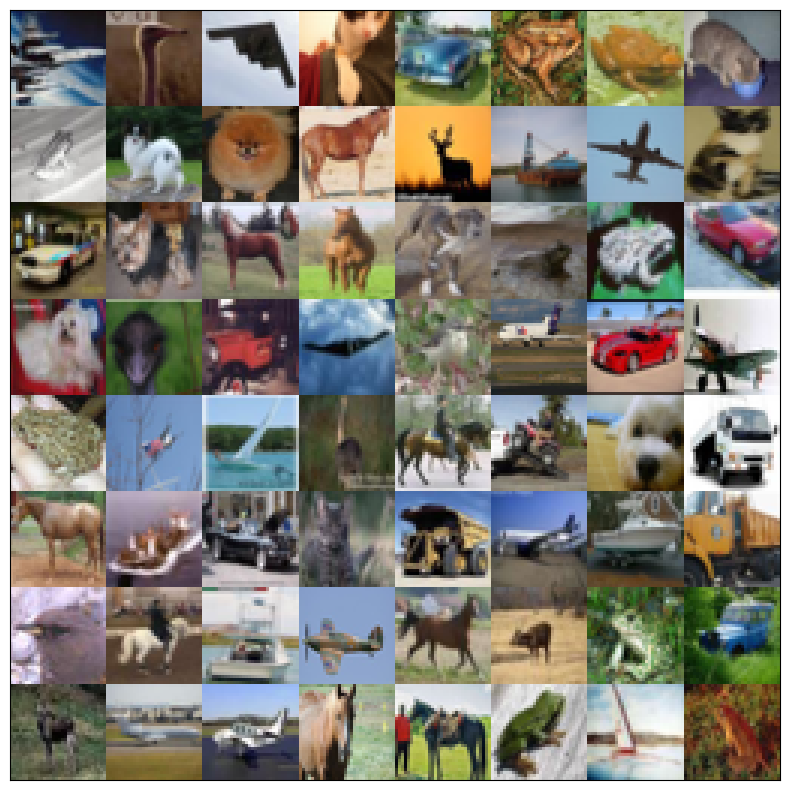

In [4]:
from torchvision.utils import make_grid

def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([]), plt.yticks([])
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images[:64], nrow=8, padding=0))

# Training (10 points)

In this section we'll train a [PreActResNet18](https://arxiv.org/abs/1603.05027) on the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

In [5]:
# @title PreActResNet

'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()

        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            downsample_conv = nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            self.shortcut = nn.Sequential(downsample_conv)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            downsample_conv = nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes: int = 10, in_channels: int = 3):
        super(PreActResNet, self).__init__()

        self.in_planes = 64
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.bn = nn.BatchNorm2d(512 * block.expansion)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.relu(self.bn(out))
        out = F.avg_pool2d(out, out.shape[-1])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def PreActResNet18(**kwargs):
    return PreActResNet(PreActBlock, [2,2,2,2], **kwargs)

def PreActResNet34(**kwargs):
    return PreActResNet(PreActBlock, [3,4,6,3], **kwargs)

def PreActResNet50(**kwargs):
    return PreActResNet(PreActBottleneck, [3,4,6,3], **kwargs)

def PreActResNet101(**kwargs):
    return PreActResNet(PreActBottleneck, [3,4,23,3], **kwargs)

def PreActResNet152(**kwargs):
    return PreActResNet(PreActBottleneck, [3,8,36,3], **kwargs)

In [6]:
def train(model, optimizer, loader, n_epochs: int = 10):
    accuracies = np.zeros(n_epochs)

    # Enter training mode
    model.train()

    # Define loss function
    loss_fn = nn.CrossEntropyLoss()

    # Iterate over epochs
    for epoch in (pbar := trange(n_epochs)):
        correct, total = 0, 0

        # TODO: Iterate over loader
        for x, y in tqdm(loader, leave=False):

            # TODO: Move batch to device
            x = x.to(device)
            y = y.to(device)

            # TODO: Compute prediction error
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_fn(outputs, y)

            # TODO: Backpropagation
            loss.backward()

            # TODO: Update counters
            optimizer.step()
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        accuracies[epoch] = 100 * correct / total
        pbar.set_description(f'Accuracy {accuracies[epoch]:.2f}%')

    return accuracies

Train the model and plot the accuracies.

In [7]:
model = PreActResNet18().to(device)
optimizer = Adam(model.parameters())

accuracies = train(model, optimizer, trainloader)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

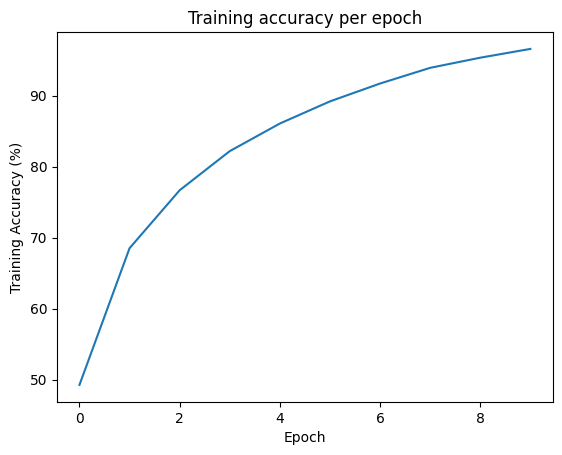

In [8]:
# TODO: Plot accuracies
plt.figure()
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.title('Training accuracy per epoch')
plt.show()

In [9]:
# Optional: Save model
torch.save(model, 'model.pth')

# Evaluation (10 points)

Now we evaluate the model.
Here we also allow the `evaluate` function to have an `attack` parameter.
The `attack` function takes in the model, the images and true labels and outputs the adversarial examples.
It can also take in a dictionary of parameters, called `attack_params`, which allows us to pass additional values for the attack such as the epsilon values.

You must return the accuracy of your model as well as the confusion matrix.

In [10]:
# @title Plot the confusion matrix

def plot_confusion_matrix(confusion_matrix, title='Confusion Matrix'):
    """
    Plot a confusion matrix with class names, normalized colors, and cell counts.

    Args:
        confusion_matrix: 2D numpy array of shape [num_classes, num_classes]
        classes: tuple of class names
        title: title for the plot
    """
    num_classes = len(classes)

    # Calculate row-wise normalization (percentage of each true class)
    row_sums = confusion_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    normalized_matrix = confusion_matrix.astype('float') / row_sums

    # Create the plot
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(normalized_matrix,
                     annot=False,  # We'll add custom annotations
                     fmt='.2f',
                     cmap='Blues',
                     cbar_kws={'label': 'Normalized Percentage'},
                     square=True,
                     xticklabels=classes,
                     yticklabels=classes)

    # Add the actual counts as text on each cell
    for i in range(num_classes):
        for j in range(num_classes):
            # Only add text if there are samples in this cell
            if confusion_matrix[i, j] > 0:
                text_color = 'white' if normalized_matrix[i, j] > 0.5 else 'black'
                ax.text(j + 0.5, i + 0.5, f'{confusion_matrix[i, j]}',
                        ha='center', va='center',
                        color=text_color, fontweight='bold')

    # Set labels and title
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(title, fontsize=14, pad=20)

    # Rotate tick labels for better readability
    plt.xticks(rotation=0, ha='right')
    plt.yticks(rotation=0)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [11]:
def evaluate(model, loader, attack=None, attack_params=dict()):
    correct, total = 0, 0
    # Initialize confusion matrix
    num_classes = len(classes)
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64, device=device)

    # TODO: Enter evaluation mode
    model.eval()

    # Iterate over loader
    for x, y in (pbar := tqdm(loader)):
        # TODO: Move batch to device
        x = x.to(device)
        y = y.to(device)

        # TODO: Perform attack
        if attack is not None:
            try:
                x_adv = attack(model, x, y, **attack_params)
            except TypeError:
                x_adv = attack(model, x, y)
        else:
            x_adv = x

        # TODO: Predict output
        outputs = model(x_adv)
        pred_labels = outputs.argmax(dim=1)

        # TODO: Update counters
        correct += (pred_labels == y).sum().item()
        total += y.size(0)

        # Update confusion matrix
        for true_label, pred_label in zip(y, pred_labels):
            confusion_matrix[true_label, pred_label] += 1

        pbar.set_description(f'Accuracy {100 * correct / total :.2f}%')

    # TODO: Return accuracy and confusion matrix
    accuracy = torch.tensor(100.0 * correct / total)

    return accuracy.item(), confusion_matrix.cpu().numpy()

  0%|          | 0/79 [00:00<?, ?it/s]

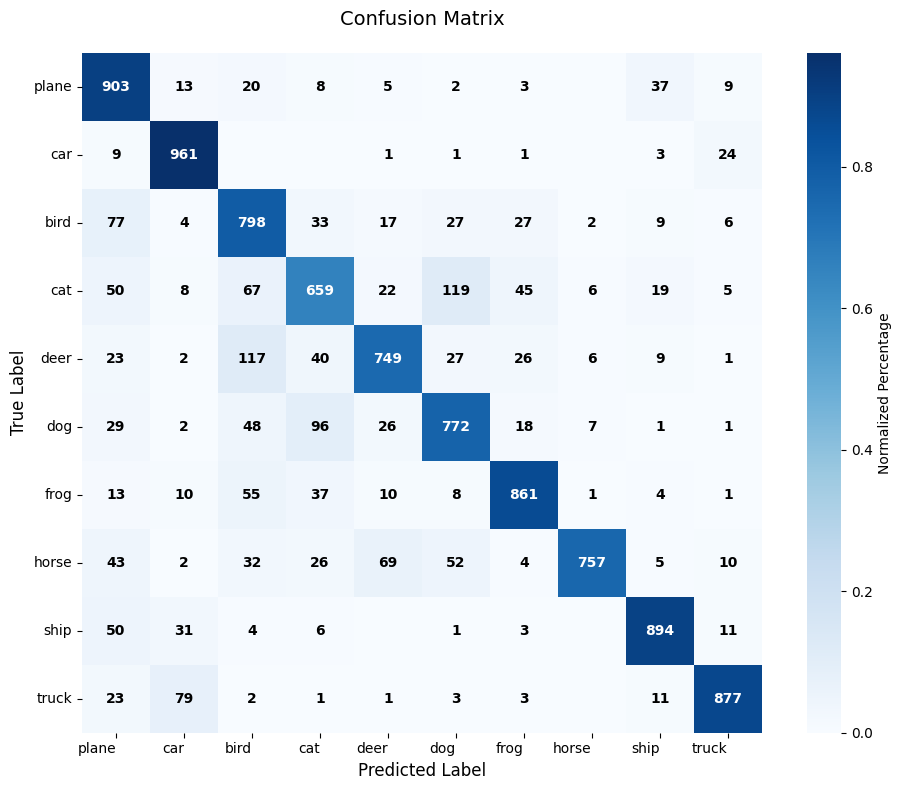

In [12]:
clean_acc, conf_mat = evaluate(model, testloader)
plot_confusion_matrix(conf_mat)

# Visualization (10 points)

In order to see the perturbations, you can try and visualize the images, perturbations and adversarial examples next to each other.

In [13]:
def visualize_adversarial_examples(model, x, y, attack, attack_params=dict(), n=5):
    model.eval()
    x_batch, y_batch = x.to(device), y.to(device)

    x_adv_batch = attack(model, x_batch, y_batch)

    fig, axes = plt.subplots(n, 3, figsize=(10, 3 * n))

    for i in range(n):
        x = x_batch[i]
        x_adv = x_adv_batch[i]
        perturbation = ((x_adv - x) / torch.max(x_adv - x) + 0.5).clamp(0, 1)

        # Get predicted labels
        pred_orig = model(x.unsqueeze(0)).argmax(dim=1).item()
        pred_adv = model(x_adv.unsqueeze(0)).argmax(dim=1).item()

        # Convert tensors to numpy for plotting
        def to_img(t):
            return t.cpu().permute(1, 2, 0).numpy()

        # Plot original
        axes[i, 0].imshow(to_img(x))
        axes[i, 0].set_title(f"Original: {classes[pred_orig]}")
        axes[i, 0].axis('off')

        # Plot perturbation
        axes[i, 1].imshow(to_img(perturbation))
        axes[i, 1].set_title("Magnified Perturbation")
        axes[i, 1].axis('off')

        # Plot adversarial
        axes[i, 2].imshow(to_img(x_adv))
        axes[i, 2].set_title(f"Adversarial: {classes[pred_adv]}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# Uniform Noise Attack (5 points)

We begin with a very simple attack.
Here we draw $\delta \sim \mathcal{U}(-\epsilon, +\epsilon)$ where $\mathcal{U}$ is a uniform distribution and $\epsilon = \frac{8}{255}$.
Don't forget to clip the pixel values to remain within the [0,1] range.

In [14]:
def unif_noise(model, x, y, eps: float = 8/255):
    # TODO: Add uniform noise to the image
    noise = torch.empty_like(x).uniform_(-eps, eps).to(x.device)
    x_adv = (x + noise)

    # TODO: Clip image to have pixel values in [0, 1] range
    x_adv = x_adv.clamp(0.0, 1.0).detach()

    return x_adv

In [15]:
noise_acc = evaluate(model, testloader, unif_noise)

  0%|          | 0/79 [00:00<?, ?it/s]

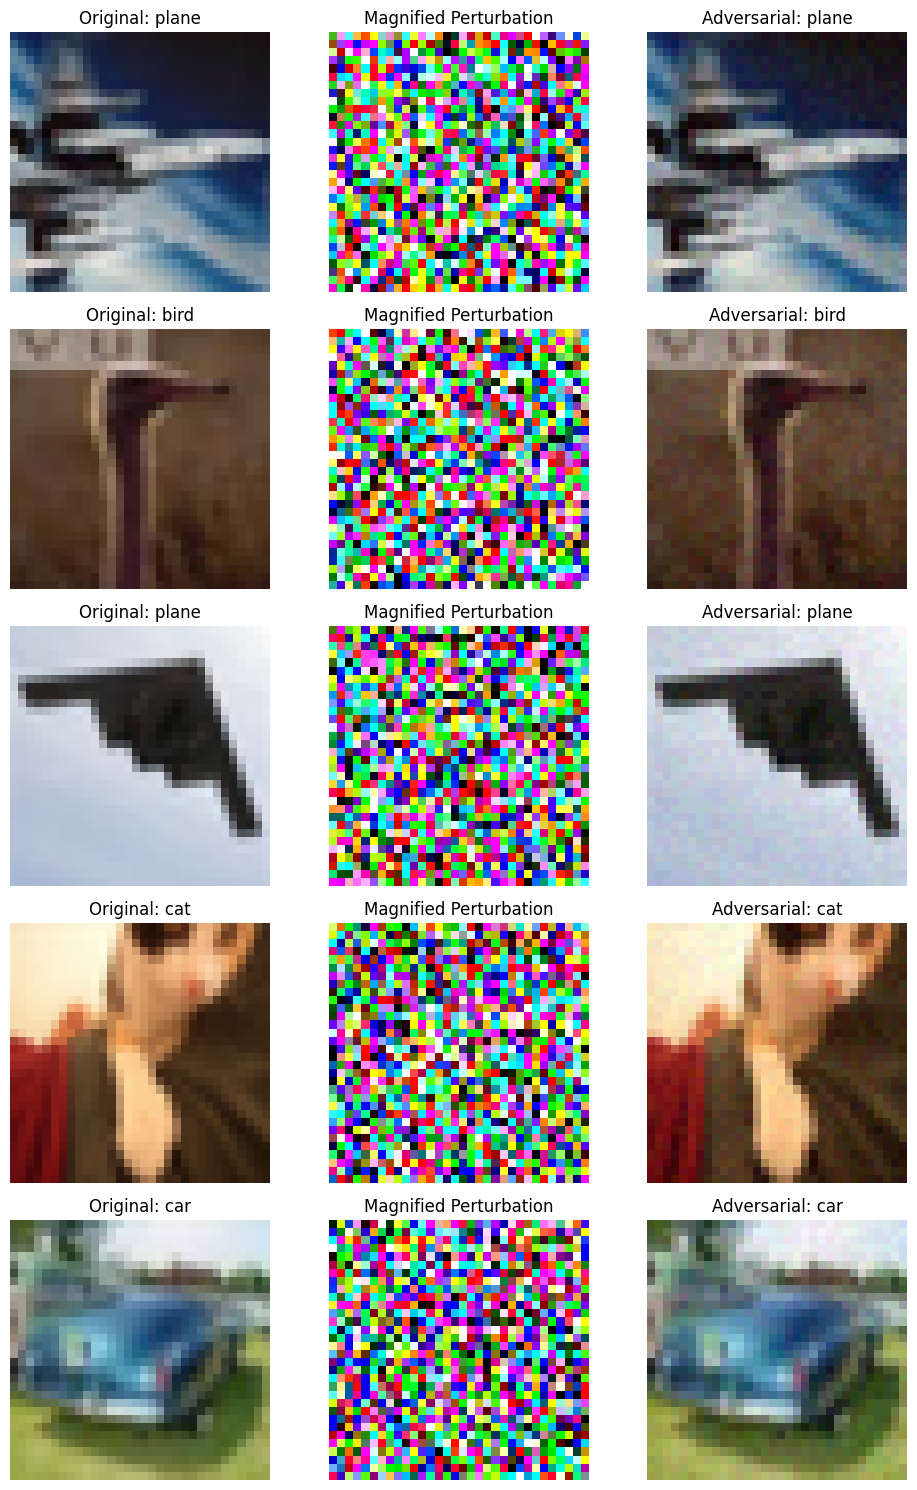

In [16]:
visualize_adversarial_examples(model, images, labels, unif_noise)

# Fast Gradient Sign Method (20 points)

Now let's move on to a stronger attack.
The [Fast Gradient Sign Method (FGSM)](https://arxiv.org/abs/1412.6572) is calculated as follows:
$$
  g = \nabla_x \mathcal{L}(x, y) \\
  x_\text{adv} = x + \epsilon \cdot \text{sign}(g)
$$
Once more we must clip the pixel values to remain within the [0,1] range.

In [17]:
def fgsm(model, x, y, eps: float = 8/255):
    # TODO: Make data require grad
    x_adv = x.clone().detach().to(device)
    x_adv.requires_grad = True

    # TODO: Calculate the loss
    outputs = model(x_adv)
    loss = nn.CrossEntropyLoss()(outputs, y.to(device))

    # TODO: Calculate the gradient
    model.zero_grad()
    if x_adv.grad is not None:
        x_adv.grad.zero_()
    loss.backward()
    grad = x_adv.grad.data

    # TODO: Compute perturbation based on sign of gradient
    x_adv = x_adv + eps * torch.sign(grad)

    # TODO: Clip image to have pixel values in [0, 1] range
    x_adv = x_adv.clamp(0.0, 1.0).detach()

    # Return adversarial examples
    return x_adv

  0%|          | 0/79 [00:00<?, ?it/s]

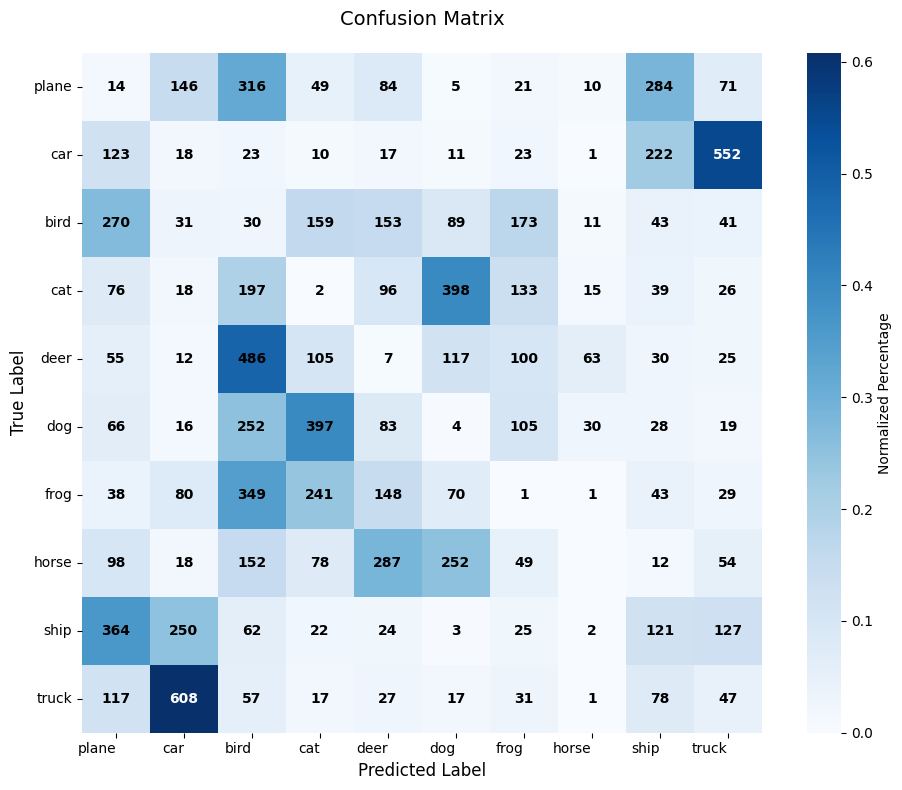

In [18]:
fgsm_acc, fgsm_cm = evaluate(model, testloader, fgsm)
plot_confusion_matrix(fgsm_cm)

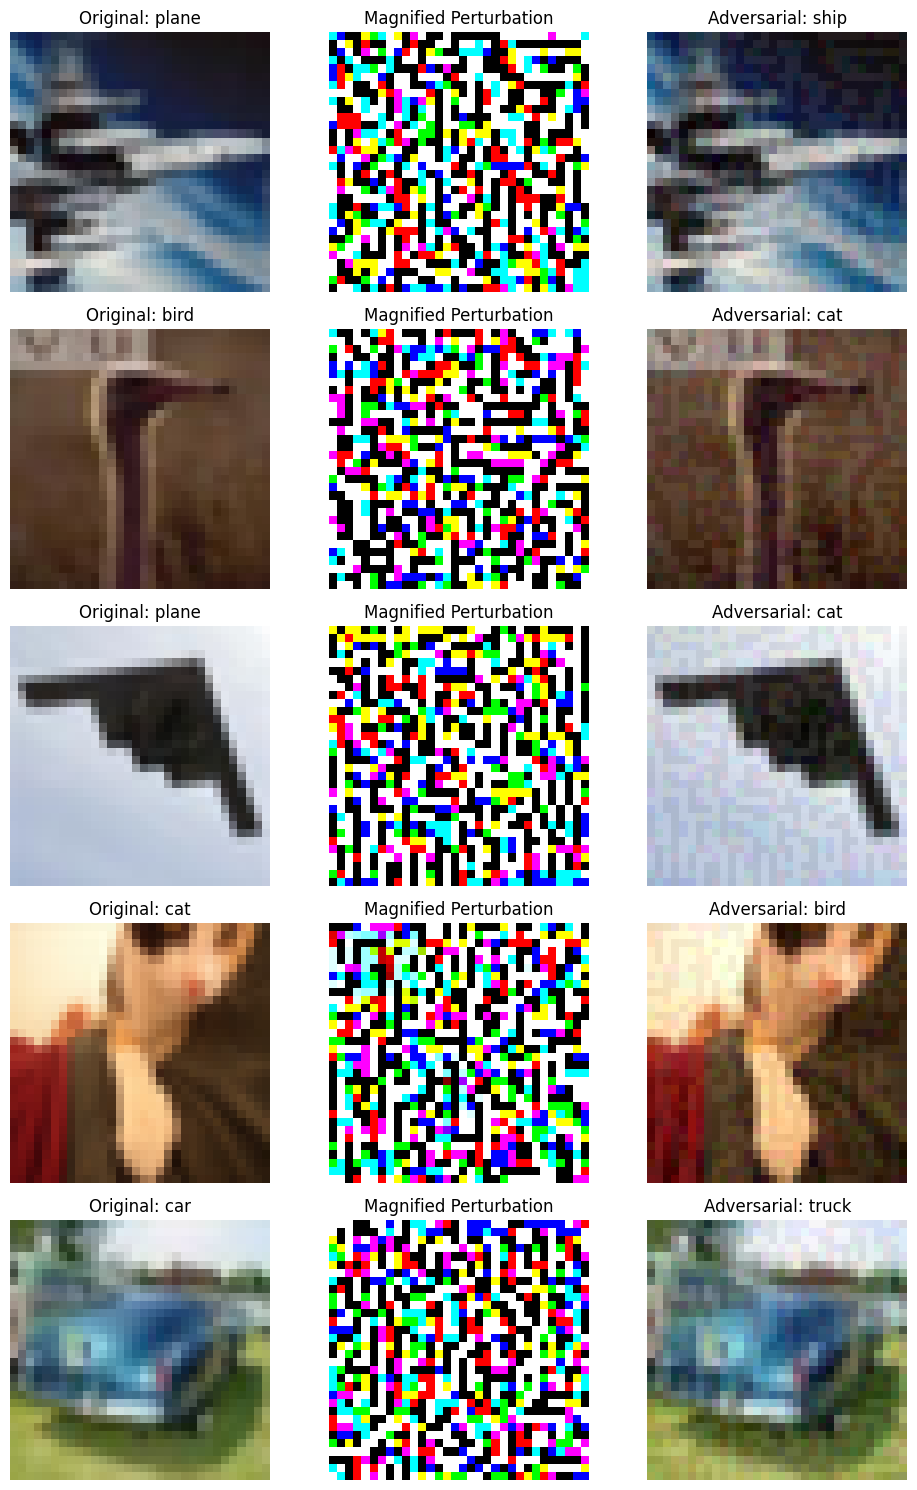

In [19]:
visualize_adversarial_examples(model, images, labels, fgsm)

Plot the accuracy of your model for $\epsilon \in [0, 8/255]$.

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

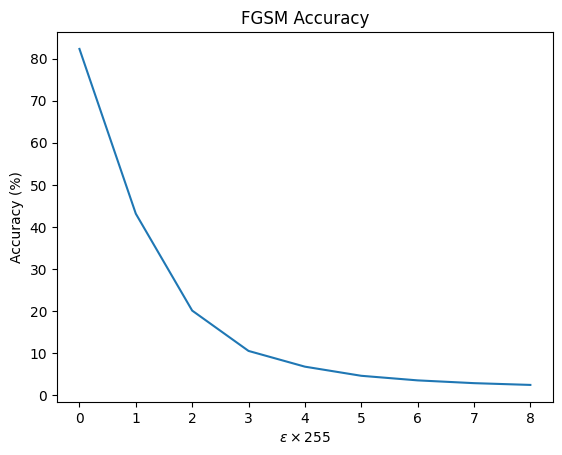

In [20]:
acc_eps = []
for i in trange(9):
    acc, cm = evaluate(model, testloader, fgsm, {'eps': i/255})
    acc_eps.append(acc)
plt.plot(acc_eps)
plt.xlabel(r'$\epsilon \times 255$')
plt.ylabel('Accuracy (%)')
plt.title('FGSM Accuracy')
plt.show()

# Carlini & Wagner Attack (30 points)

While [FGSM](https://arxiv.org/abs/1412.6572) is a powerful attack, [CW](https://arxiv.org/abs/1608.04644) is even more powerful.

In [35]:
# f-function in the paper
def f(outputs, labels, kappa):
    one_hot = torch.eye(outputs.shape[1]).to(device)[labels]
    # TODO: find the max logit other than the target class
    other = torch.max((1 - one_hot) * outputs, dim=1)[0]
    # TODO: get the target class's logit
    real = torch.max(one_hot * outputs, dim=1)[0]
    # TODO clamp the difference
    out = torch.clamp(real - other, min=-kappa)
    return out

In [39]:
def cw(model, x, y, c=1, kappa=0, steps=10, lr=0.01):
    x = x.clone().detach().to(device)

    # Perform atanh
    w = torch.atanh(x * 2 - 1).detach()
    w.requires_grad = True

    best_adv = x.clone().detach()
    best_L2 = 1e10 * torch.ones((len(x))).to(device)
    prev_cost = 1e10
    dim = len(x.shape)

    MSELoss = nn.MSELoss(reduction="none")
    Flatten = nn.Flatten()

    optimizer = torch.optim.Adam([w], lr=lr)

    for step in range(steps):
        # TODO: Get adversarial images
        x_adv = 1 / 2 * (torch.tanh(w) + 1)

        # TODO: Calculate loss
        current_L2 = MSELoss(Flatten(x_adv), Flatten(x)).sum(dim=1)
        L2_loss = current_L2.sum()

        pred = model(x_adv)
        f_loss = f(pred, y, kappa).sum()

        cost = L2_loss + c * f_loss

        # TODO: Backpropagation
        optimizer.zero_grad()
        cost.backward()

        # TODO: Update adversarial images
        optimizer.step()

        # TODO: If the attack is not targeted, simply make these two values unequal
        is_adv = pred.argmax(dim=1) != y

        # TODO: Filter out images that get either correct predictions or non-decreasing loss, i.e., only images that are both misclassified and loss-decreasing are left
        improved = (current_L2 < best_L2) & is_adv
        best_L2 = torch.where(improved, current_L2, best_L2)

        mask = improved.view([-1] + [1] * (dim - 1)).float()
        best_adv = mask * x_adv.detach() + (1 - mask) * best_adv

        # Early stop when loss does not converge. max(.,1) To prevent MODULO BY ZERO error in the next step.
        if step % max(steps // 10, 1) == 0:
            if cost.item() > prev_cost:
                return best_adv
            prev_cost = cost.item()

    return best_adv

  0%|          | 0/79 [00:00<?, ?it/s]

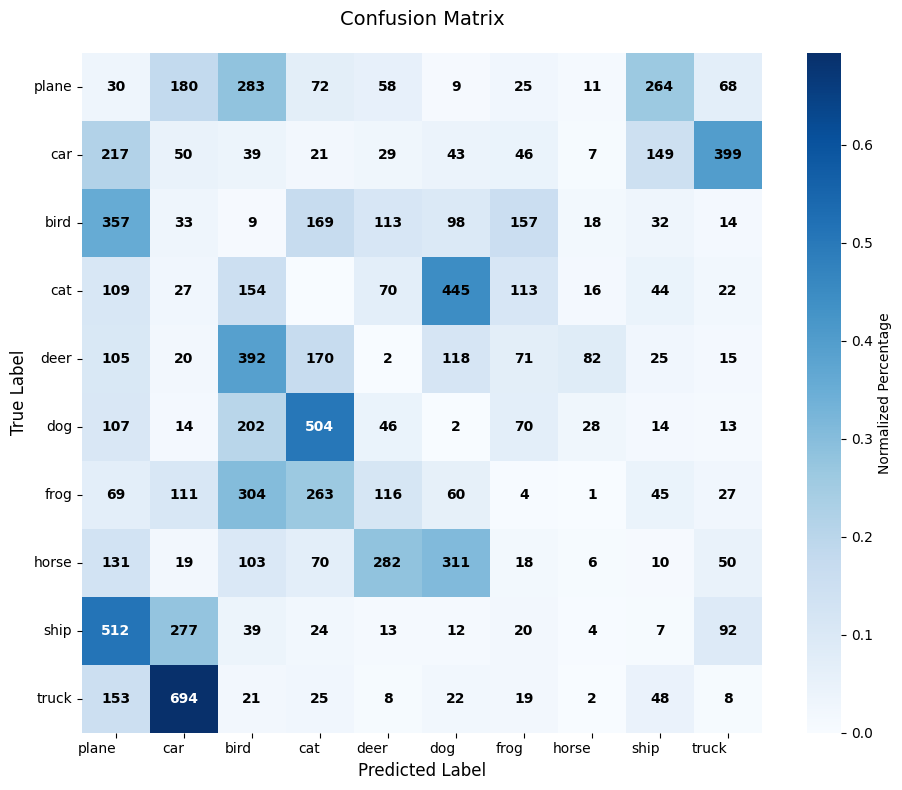

In [40]:
cw_acc, cw_cm = evaluate(model, testloader, cw)
plot_confusion_matrix(cw_cm)

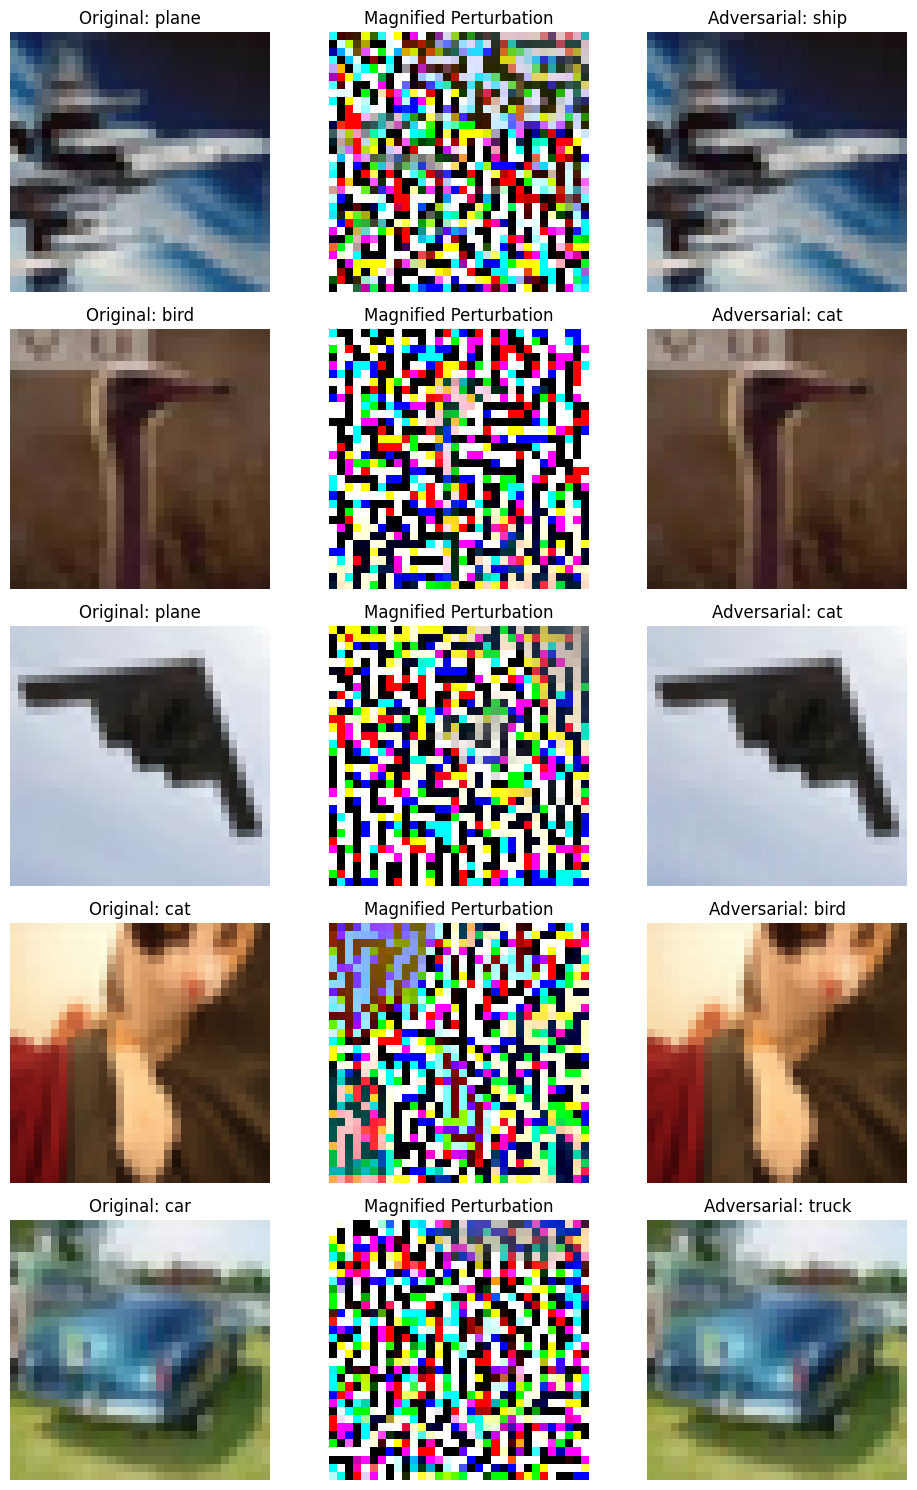

In [41]:
visualize_adversarial_examples(model, images, labels, cw)

# Load Models (5 points)

Here we load a model from [RobustBench](https://robustbench.github.io).
In this case we choose the model from [this paper](https://arxiv.org/abs/2110.09468) which uses a [PreActResNet18](https://arxiv.org/abs/1603.05027) architecture.

In [42]:
# @title Installations
! pip install git+https://github.com/fra31/auto-attack
! pip install robustbench

  Cloning https://github.com/fra31/auto-attack to /tmp/pip-req-build-9box0kki
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack /tmp/pip-req-build-9box0kki
  Resolved https://github.com/fra31/auto-attack to commit a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Preparing metadata (setup.py) ... done
  Created wheel for autoattack: filename=autoattack-0.1-py3-none-any.whl size=36228 sha256=c74cb71ceb3f5d5ec6e4b8eb43cbd968bfb787e0108596dc66928b3daaefc599
  Stored in directory: /tmp/pip-ephem-wheel-cache-yv_1nc74/wheels/5a/06/2e/e5e2d58dcb2d67ed9e5dbbd7752368f6c68c97cd3f629ba1b4
Successfully built autoattack
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [43]:
from robustbench.utils import load_model

model = load_model(model_name='Gowal2021Improving_R18_ddpm_100m', dataset='cifar10', threat_model='Linf')
model = model.to(device)

Downloading...
From (original): https://drive.google.com/uc?id=1-0EuCJashqSXEkkd1DOzFA4tH8KL2kim
From (redirected): https://drive.google.com/uc?id=1-0EuCJashqSXEkkd1DOzFA4tH8KL2kim&confirm=t&uuid=dcc53379-50b1-4884-8697-0488b3cfbb6d
To: /content/models/cifar10/Linf/Gowal2021Improving_R18_ddpm_100m.pt
100%|██████████| 50.3M/50.3M [00:01<00:00, 47.6MB/s]


Now repeat the evaluations steps on this new model and compare the results.

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

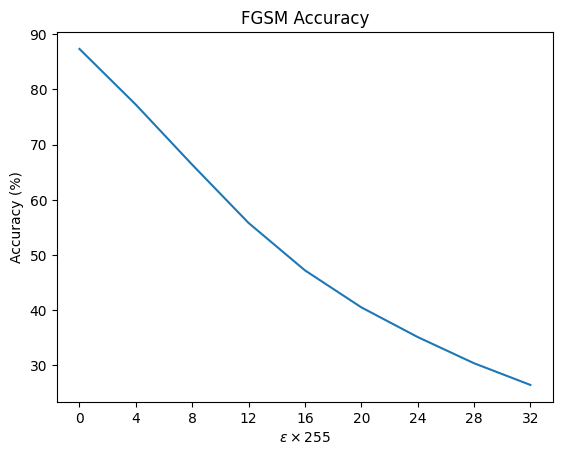

In [44]:
# Plot FGSM accuracy for ϵ in [0, 32/255]
acc_eps = []
for i in range(9):
    acc, _ = evaluate(model, testloader, fgsm, {'eps': 4*i/255})
    acc_eps.append(acc)
plt.plot(acc_eps)
plt.xlabel(r'$\epsilon \times 255$')
plt.xticks(np.arange(9), 4 * np.arange(9))
plt.ylabel('Accuracy (%)')
plt.title('FGSM Accuracy')
plt.show()

In [45]:
clean_acc, _ = evaluate(model, testloader)
noise_acc, _ = evaluate(model, testloader, unif_noise)
fgsm_acc, _ = evaluate(model, testloader, fgsm)
cw_acc, _ = evaluate(model, testloader, cw)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

In [46]:
print(f'Clean {clean_acc:.2f}% | Noise {noise_acc:.2f}% | FGSM {fgsm_acc:.2f}% | CW {cw_acc:.2f}%')

Clean 87.35% | Noise 87.25% | FGSM 66.38% | CW 65.55%


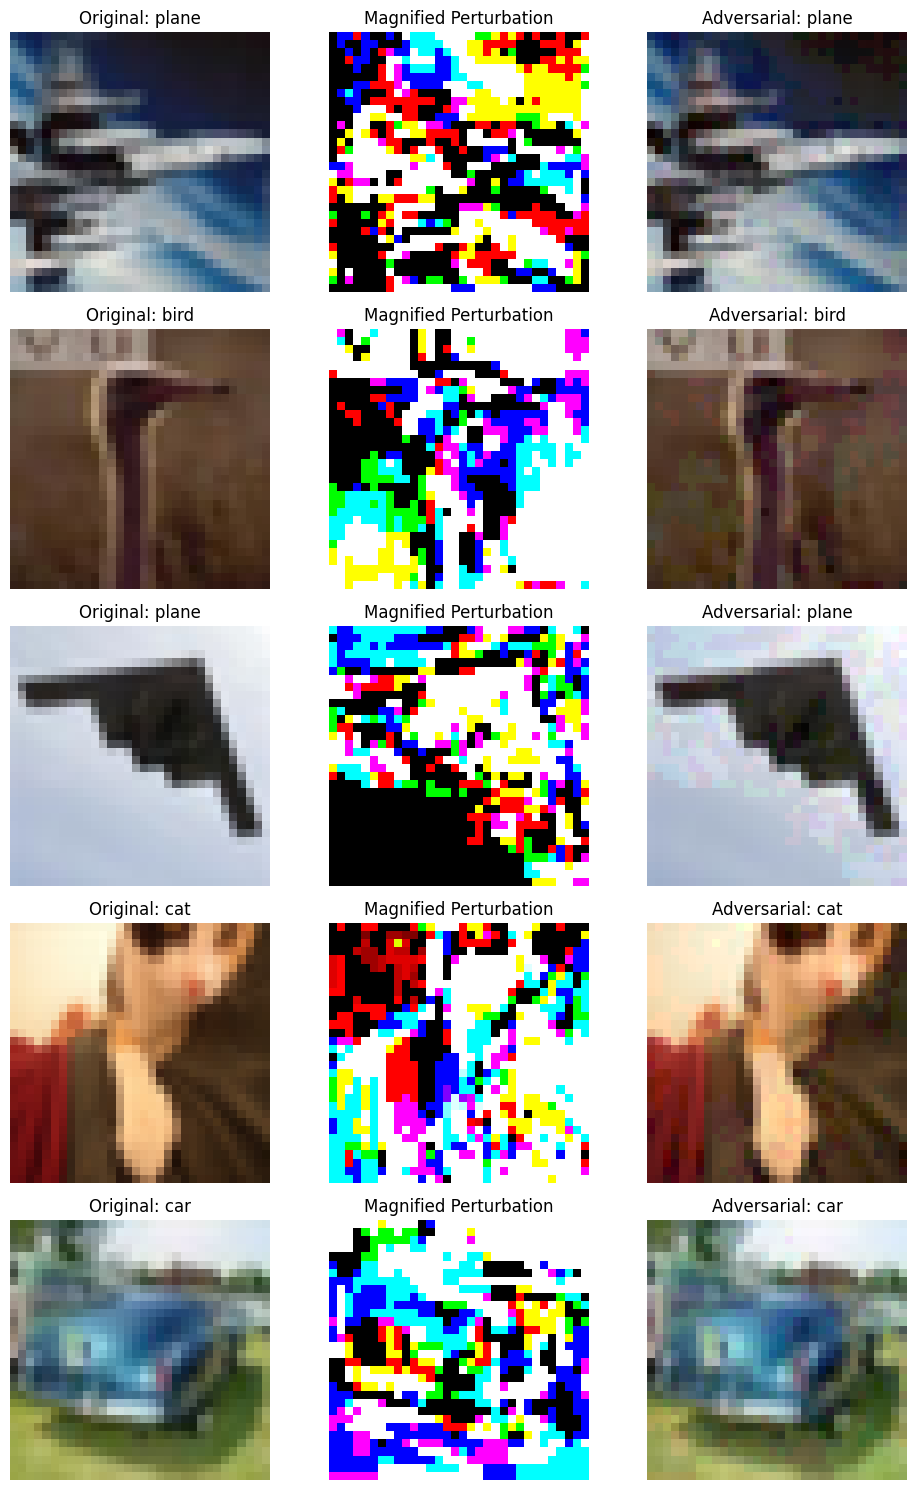

In [47]:
visualize_adversarial_examples(model, images, labels, fgsm, attack_params={'eps': 16/255})